# This Notebook train 10 VAE to generate each a digit, then train a classifieur to solve mnist only with the VAEs. : result 95% accuracy without much finetuning

In [1]:
%matplotlib inline



import itertools
import math
import time

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from IPython import display
from torch.autograd import Variable


from __future__ import print_function
import argparse
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

#import visdom
#vis = visdom.Visdom()
#vis.env = 'vae_dcgan'

In [2]:
print(torch.cuda.is_available())

True


In [3]:
cuda =  torch.cuda.is_available()
batch_size=128
log_interval=100
epochs=150
seed=1
saveInt=25

ouft='.'
niter=25
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
nz=100
ngf=28
nc=3
ndf=28

imageSize=32

In [4]:
class Classif(nn.Module):
    def __init__(self):
        super(Classif, self).__init__()

        self.fc1 = nn.Linear(3*1024, 400)
        self.fc2 = nn.Linear(400, 100)
        self.fc3 = nn.Linear(100, 10)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def classif(self, x):
        h1 = self.relu(self.fc1(x))
        h2 = self.relu(self.fc2(h1))
        return F.log_softmax(self.fc3(h2))


    def forward(self, x):
        return self.classif(x.view(-1, 3*1024))

In [5]:
class _Sampler(nn.Module):
    def __init__(self):
        super(_Sampler, self).__init__()
        
    def forward(self,input):
        mu = input[0]
        logvar = input[1]
        
        std = logvar.mul(0.5).exp_() #calculate the STDEV
        if cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_() #random normalized noise
        else:
            eps = torch.FloatTensor(std.size()).normal_() #random normalized noise
        eps = Variable(eps)
        return eps.mul(std).add_(mu) 


In [6]:
class _Encoder(nn.Module):
    def __init__(self,imageSize):
        super(_Encoder, self).__init__()
        
        n = math.log(imageSize)/math.log(2) #no log 2 available
        
        assert n==round(n),'imageSize must be a power of 2'
        assert n>=3,'imageSize must be at least 8'
        n=int(n)


        self.conv1 = nn.Conv2d(ngf * 2**(n-3), nz, 4)
        self.conv2 = nn.Conv2d(ngf * 2**(n-3), nz, 4)

        self.encoder = nn.Sequential()
        # input is (nc) x 64 x 64
        self.encoder.add_module('input-conv',nn.Conv2d(nc, ngf, 4, 2, 1, bias=False))
        self.encoder.add_module('input-relu',nn.LeakyReLU(0.2, inplace=True))
        for i in range(n-3):
            # state size. (ngf) x 32 x 32
            self.encoder.add_module('pyramid.{0}-{1}.conv'.format(ngf*2**i, ngf * 2**(i+1)), nn.Conv2d(ngf*2**(i), ngf * 2**(i+1), 4, 2, 1, bias=False))
            self.encoder.add_module('pyramid.{0}.batchnorm'.format(ngf * 2**(i+1)), nn.BatchNorm2d(ngf * 2**(i+1)))
            self.encoder.add_module('pyramid.{0}.relu'.format(ngf * 2**(i+1)), nn.LeakyReLU(0.2, inplace=True))

        # state size. (ngf*8) x 4 x 4

    def forward(self,input):
        output = self.encoder(input)
        return [self.conv1(output),self.conv2(output)]

In [7]:
class _netG(nn.Module):
    def __init__(self, imageSize):
        super(_netG, self).__init__()
        self.encoder = _Encoder(imageSize)
        self.sampler = _Sampler()
        
        n = math.log(imageSize)/math.log(2) #no log 2 available
        
        assert n==round(n),'imageSize must be a power of 2'
        assert n>=3,'imageSize must be at least 8'
        n=int(n)

        self.decoder = nn.Sequential()
        # input is Z, going into a convolution
        self.decoder.add_module('input-conv', nn.ConvTranspose2d(nz, ngf * 2**(n-3), 4, 1, 0, bias=False))
        self.decoder.add_module('input-batchnorm', nn.BatchNorm2d(ngf * 2**(n-3)))
        self.decoder.add_module('input-relu', nn.LeakyReLU(0.2, inplace=True))

        # state size. (ngf * 2**(n-3)) x 4 x 4

        for i in range(n-3, 0, -1):
            self.decoder.add_module('pyramid.{0}-{1}.conv'.format(ngf*2**i, ngf * 2**(i-1)),nn.ConvTranspose2d(ngf * 2**i, ngf * 2**(i-1), 4, 2, 1, bias=False))
            self.decoder.add_module('pyramid.{0}.batchnorm'.format(ngf * 2**(i-1)), nn.BatchNorm2d(ngf * 2**(i-1)))
            self.decoder.add_module('pyramid.{0}.relu'.format(ngf * 2**(i-1)), nn.LeakyReLU(0.2, inplace=True))

        self.decoder.add_module('ouput-conv', nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False))
        self.decoder.add_module('output-tanh', nn.Tanh())


    def forward(self, input):
        output = self.encoder(input)
        output = self.sampler(output)
        output = self.decoder(output)
        return output
    
    def make_cuda(self):
        self.encoder.cuda()
        self.sampler.cuda()
        self.decoder.cuda()

In [8]:
class _netD(nn.Module):
    def __init__(self, imageSize):
        super(_netD, self).__init__()
        n = math.log(imageSize)/math.log(2) #no log 2 available
        
        assert n==round(n),'imageSize must be a power of 2'
        assert n>=3,'imageSize must be at least 8'
        n=int(n)
        self.main = nn.Sequential()

        # input is (nc) x 64 x 64
        self.main.add_module('input-conv', nn.Conv2d(nc, ndf, 4, 2, 1, bias=False))
        self.main.add_module('relu', nn.LeakyReLU(0.2, inplace=True))

        # state size. (ndf) x 32 x 32
        for i in range(n-3):
            self.main.add_module('pyramid.{0}-{1}.conv'.format(ngf*2**(i), ngf * 2**(i+1)), nn.Conv2d(ndf * 2 ** (i), ndf * 2 ** (i+1), 4, 2, 1, bias=False))
            self.main.add_module('pyramid.{0}.batchnorm'.format(ngf * 2**(i+1)), nn.BatchNorm2d(ndf * 2 ** (i+1)))
            self.main.add_module('pyramid.{0}.relu'.format(ngf * 2**(i+1)), nn.LeakyReLU(0.2, inplace=True))

        self.main.add_module('output-conv', nn.Conv2d(ndf * 2**(n-3), 1, 4, 1, 0, bias=False))
        self.main.add_module('output-sigmoid', nn.Sigmoid())
        

    def forward(self, input):
            output = self.main(input)
            return output.view(-1, 1)

In [9]:
def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [11]:
def get_list_batch():
    list_digits=[[],[],[],[],[],[],[],[],[],[]]
    for batch_idx, (data, target) in enumerate(train_loader):
        batch_size=len(target)
        for i in range(batch_size):
            #list_digits[target[i]].append(batch_idx*batch_size+i)
            list_digits[target[i]].append(data[i])
    return list_digits

def get_batch(list_digits, digit, batch_size):
    liste=list_digits[digit]
    size_list=len(liste)
    plt.imshow(liste[0].numpy()[0])
    batch=np.zeros((batch_size,3,imageSize,imageSize))
    for i in range(batch_size):
        indice=np.random.randint(0, size_list)
        batch[i]=liste[indice].numpy()
    return batch

In [12]:
def add_memories(epoch,data, target):
    mem_size=int(batch_size*epoch/(epochs*2))
    data_mem, label_mem=get_memories(mem_size)
    data[batch_size-mem_size:]=data_mem
    target[batch_size-mem_size:]=label_mem
    #target_discr[batch_size-mem_size:]=torch.zeros(mem_size)
    return data, target
    
def get_memories(size):
    data=np.zeros((size,3,imageSize,imageSize))
    target=np.zeros((size))
    for i in range(size):
        hidden_vector=torch.randn((1,20))
        hidden_vector=Variable(hidden_vector.cuda())
        
        classif=model.classif(hidden_vector)
        target[i]=int(classif.data.max(1)[1].cpu().numpy())
        data[i]=model.decode(hidden_vector).data.cpu().numpy().reshape(3,imageSize,imageSize)
        return torch.from_numpy(data), torch.from_numpy(target)

In [13]:
lr=0.0002
beta1=0.5

netG = _netG(imageSize)
netG.apply(weights_init)

netD = _netD(imageSize)
netD.apply(weights_init)

criterion = nn.BCELoss()
MSECriterion = nn.MSELoss()

input = torch.FloatTensor(batch_size, 3, imageSize, imageSize)
noise = torch.FloatTensor(batch_size, nz, 1, 1)
fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1)
label = torch.FloatTensor(batch_size)
real_label = 1
fake_label = 0

if cuda:
    netD.cuda()
    netG.make_cuda()
    criterion.cuda()
    MSECriterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

input = Variable(input)
label = Variable(label)
noise = Variable(noise)
fixed_noise = Variable(fixed_noise)

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

gen_win = None
rec_win = None

In [14]:
def train(epoch):
    gen_win = None
    rec_win = None
    for i, data in enumerate(train_loader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu, _ = data
        batch_size = real_cpu.size(0)
        input.data.resize_(real_cpu.size()).copy_(real_cpu)
        label.data.resize_(real_cpu.size(0)).fill_(real_label)

        output = netD(input)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake
        noise.data.resize_(batch_size, nz, 1, 1)
        noise.data.normal_(0, 1)
        gen = netG.decoder(noise)
        #gen_win = vis.image(gen.data[0].cpu()*0.5+0.5,win = gen_win)
        label.data.fill_(fake_label)
        output = netD(gen.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()
        ############################
        # (2) Update G network: VAE
        ###########################
        
        encoded = netG.encoder(input)
        mu = encoded[0]
        logvar = encoded[1]
        
        KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
        KLD = torch.sum(KLD_element).mul_(-0.5)
        
        sampled = netG.sampler(encoded)
        rec = netG.decoder(sampled)
        #rec_win = vis.image(rec.data[0].cpu()*0.5+0.5,win = rec_win)
        
        MSEerr = MSECriterion(rec,input)
        
        VAEerr = KLD + MSEerr;
        VAEerr.backward()
        optimizerG.step()

        ############################
        # (3) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.data.fill_(real_label)  # fake labels are real for generator cost

        rec = netG(input) # this tensor is freed from mem at this point
        output = netD(rec)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_VAE: %.4f Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(train_loader),
                 VAEerr.data[0], errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2))

    if epoch%saveInt == 0 and epoch!=0:
        torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
        torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))
    
    
def test(epoch):
    model_classif.eval()
    test_loss = 0
    test_loss_classif = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data = data.cuda()
            target = target.cuda()
        data = Variable(data, volatile=True)
        target = Variable(target, volatile=True)
        #recon_batch, classif, mu, logvar = model_classif(data)
        classif = model_classif(data)
        #test_loss += loss_function(recon_batch, data, mu, logvar).data[0]
        
        
        test_loss_classif  += F.nll_loss(classif, target, size_average=False).data[0] # sum up batch loss
        pred = classif.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss_classif , correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))

In [15]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}


transform_train = transforms.Compose([
    #transforms.RandomCrop(32, padding=4),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data_cifar10', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data_cifar10', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

list_digits=get_list_batch()



Files already downloaded and verified
Files already downloaded and verified


## Print some image

torch.Size([128, 3, 32, 32])
(3, 32, 32)


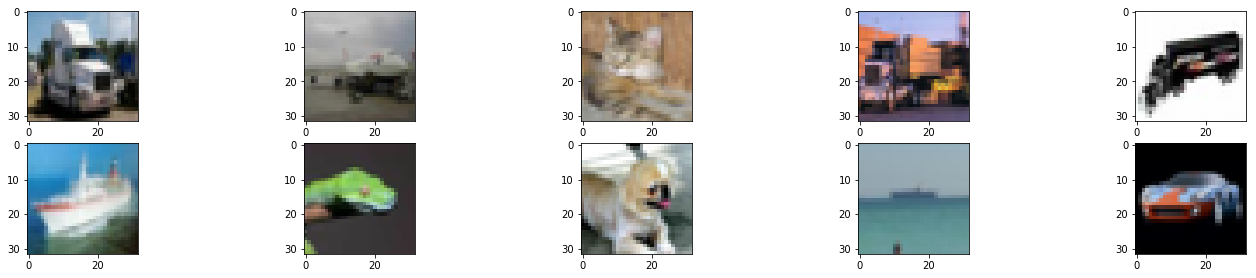

In [16]:
width = 24
height = 24
plt.figure(figsize=(width, height))

batch=0
for batch_idx, (data, target) in enumerate(train_loader):
    print(data.shape)
    batch=data[:10,:,:,:].cpu().numpy()
    break
print(batch[1].shape)
plt.imshow(np.transpose(batch[1], (1, 2, 0)))
#plt.imshow(batch[1].reshape(32,32,3))
for i in range(10):
    plt.subplot(10,5,i+1)
    sigma=np.array([0.4914, 0.4822, 0.4465])
    mu=np.array([0.2023, 0.1994, 0.2010])
    batch[i]=batch[i]*mu[:,None, None] + sigma[:,None, None]
    plt.imshow(np.transpose(batch[i], (1, 2, 0)))

In [18]:
def print_sample():
    dec=netG
    noise.data.resize_(batch_size, nz, 1, 1)
    noise.data.normal_(0, 1)
    gen = netG.decoder(noise)


    width = 24
    height = 48
    plt.figure(figsize=(width, height))

    hidden_vector=torch.randn((10,20))
    hidden_vector=Variable(hidden_vector.cuda())

    img=gen.data.cpu().numpy().reshape((batch_size,3,imageSize,imageSize))

    for i in range(20):
        plt.subplot(20,5,i+1)
        sigma=np.array([0.4914, 0.4822, 0.4465])
        mu=np.array([0.2023, 0.1994, 0.2010])
        img[i]=img[i]*mu[:,None, None] + sigma[:,None, None]
        plt.imshow(np.transpose(img[i], (1, 2, 0)))
    plt.show()    

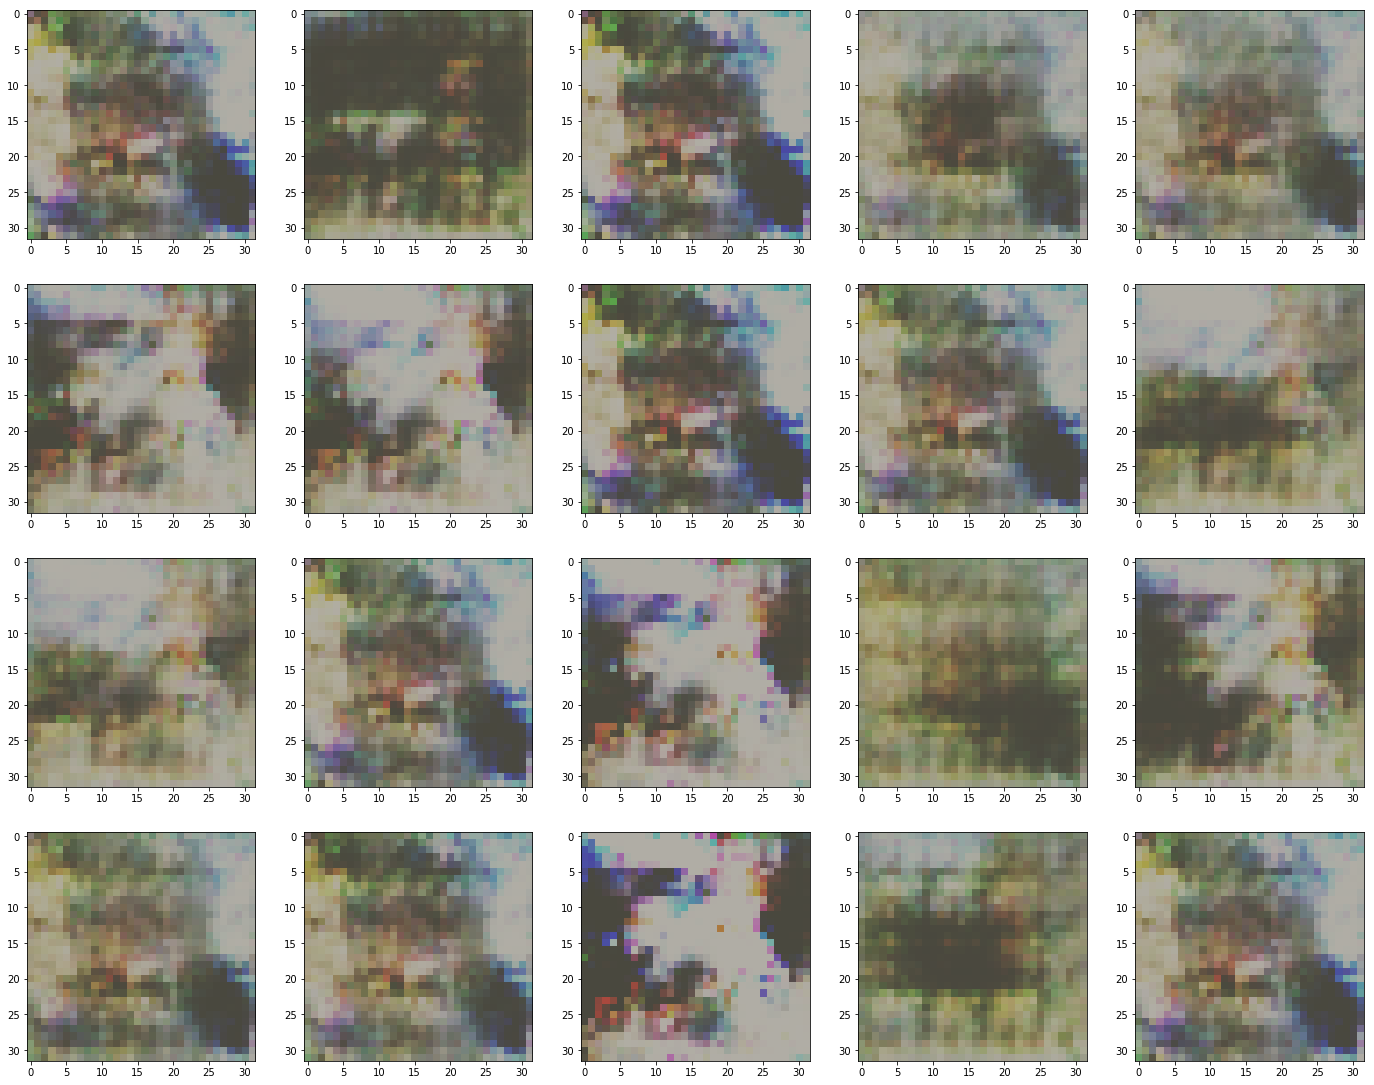

[25/25][0/391] Loss_VAE: 2.2588 Loss_D: 0.5267 Loss_G: 4.3766 D(x): 0.7017 D(G(z)): 0.0132 / 0.0834
[25/25][1/391] Loss_VAE: 2.2901 Loss_D: 0.2895 Loss_G: 3.4804 D(x): 0.8934 D(G(z)): 0.1075 / 0.0710
[25/25][2/391] Loss_VAE: 2.6710 Loss_D: 0.4413 Loss_G: 4.0085 D(x): 0.9294 D(G(z)): 0.1876 / 0.0591
[25/25][3/391] Loss_VAE: 2.4877 Loss_D: 0.4068 Loss_G: 2.8987 D(x): 0.8153 D(G(z)): 0.0721 / 0.1235
[25/25][4/391] Loss_VAE: 2.6230 Loss_D: 0.1918 Loss_G: 2.9387 D(x): 0.9366 D(G(z)): 0.0966 / 0.0845
[25/25][5/391] Loss_VAE: 2.5103 Loss_D: 0.2755 Loss_G: 2.7262 D(x): 0.8737 D(G(z)): 0.0959 / 0.1137
[25/25][6/391] Loss_VAE: 2.4639 Loss_D: 0.3784 Loss_G: 3.5865 D(x): 0.8771 D(G(z)): 0.1729 / 0.0493
[25/25][7/391] Loss_VAE: 2.4750 Loss_D: 0.2856 Loss_G: 3.2100 D(x): 0.8492 D(G(z)): 0.0679 / 0.0837
[25/25][8/391] Loss_VAE: 2.5961 Loss_D: 0.2855 Loss_G: 3.0984 D(x): 0.9086 D(G(z)): 0.1386 / 0.0776
[25/25][9/391] Loss_VAE: 2.4457 Loss_D: 0.2434 Loss_G: 3.8379 D(x): 0.9005 D(G(z)): 0.0978 / 0.0391


[25/25][84/391] Loss_VAE: 2.8385 Loss_D: 0.0988 Loss_G: 3.2518 D(x): 0.9526 D(G(z)): 0.0452 / 0.0541
[25/25][85/391] Loss_VAE: 2.6667 Loss_D: 0.0977 Loss_G: 3.1893 D(x): 0.9572 D(G(z)): 0.0490 / 0.0544
[25/25][86/391] Loss_VAE: 2.2128 Loss_D: 0.1560 Loss_G: 3.8471 D(x): 0.9441 D(G(z)): 0.0845 / 0.0311
[25/25][87/391] Loss_VAE: 2.3544 Loss_D: 0.1388 Loss_G: 3.0895 D(x): 0.9169 D(G(z)): 0.0384 / 0.0647
[25/25][88/391] Loss_VAE: 2.5428 Loss_D: 0.1488 Loss_G: 4.2291 D(x): 0.9590 D(G(z)): 0.0944 / 0.0313
[25/25][89/391] Loss_VAE: 2.5189 Loss_D: 0.1322 Loss_G: 3.8070 D(x): 0.9203 D(G(z)): 0.0336 / 0.0349
[25/25][90/391] Loss_VAE: 2.3844 Loss_D: 0.1026 Loss_G: 3.3449 D(x): 0.9573 D(G(z)): 0.0516 / 0.0502
[25/25][91/391] Loss_VAE: 2.3103 Loss_D: 0.0882 Loss_G: 3.3926 D(x): 0.9694 D(G(z)): 0.0520 / 0.0427
[25/25][92/391] Loss_VAE: 2.1936 Loss_D: 0.1132 Loss_G: 3.2937 D(x): 0.9413 D(G(z)): 0.0441 / 0.0502
[25/25][93/391] Loss_VAE: 2.1098 Loss_D: 0.1155 Loss_G: 3.5914 D(x): 0.9585 D(G(z)): 0.0644

[25/25][168/391] Loss_VAE: 2.1836 Loss_D: 0.0931 Loss_G: 3.6475 D(x): 0.9561 D(G(z)): 0.0368 / 0.0412
[25/25][169/391] Loss_VAE: 2.0966 Loss_D: 0.0993 Loss_G: 3.8063 D(x): 0.9593 D(G(z)): 0.0505 / 0.0346
[25/25][170/391] Loss_VAE: 1.9786 Loss_D: 0.1189 Loss_G: 3.6327 D(x): 0.9460 D(G(z)): 0.0515 / 0.0377
[25/25][171/391] Loss_VAE: 2.1079 Loss_D: 0.1097 Loss_G: 3.3841 D(x): 0.9488 D(G(z)): 0.0476 / 0.0535
[25/25][172/391] Loss_VAE: 2.3087 Loss_D: 0.0951 Loss_G: 4.2261 D(x): 0.9716 D(G(z)): 0.0591 / 0.0274
[25/25][173/391] Loss_VAE: 2.3493 Loss_D: 0.1156 Loss_G: 3.9390 D(x): 0.9453 D(G(z)): 0.0441 / 0.0334
[25/25][174/391] Loss_VAE: 2.4385 Loss_D: 0.1120 Loss_G: 3.0298 D(x): 0.9338 D(G(z)): 0.0333 / 0.0813
[25/25][175/391] Loss_VAE: 2.6242 Loss_D: 0.1527 Loss_G: 4.6130 D(x): 0.9798 D(G(z)): 0.1105 / 0.0184
[25/25][176/391] Loss_VAE: 2.6651 Loss_D: 0.0756 Loss_G: 4.9401 D(x): 0.9545 D(G(z)): 0.0247 / 0.0146
[25/25][177/391] Loss_VAE: 3.3333 Loss_D: 0.1011 Loss_G: 3.3801 D(x): 0.9401 D(G(z

[25/25][252/391] Loss_VAE: 2.6044 Loss_D: 0.0312 Loss_G: 4.6819 D(x): 0.9901 D(G(z)): 0.0203 / 0.0153
[25/25][253/391] Loss_VAE: 2.8726 Loss_D: 0.0890 Loss_G: 3.7234 D(x): 0.9438 D(G(z)): 0.0232 / 0.0380
[25/25][254/391] Loss_VAE: 2.2566 Loss_D: 0.1024 Loss_G: 5.3141 D(x): 0.9854 D(G(z)): 0.0792 / 0.0082
[25/25][255/391] Loss_VAE: 2.2746 Loss_D: 0.0710 Loss_G: 5.1168 D(x): 0.9570 D(G(z)): 0.0156 / 0.0132
[25/25][256/391] Loss_VAE: 2.0532 Loss_D: 0.0426 Loss_G: 3.8716 D(x): 0.9709 D(G(z)): 0.0112 / 0.0318
[25/25][257/391] Loss_VAE: 2.1078 Loss_D: 0.0827 Loss_G: 4.8932 D(x): 0.9760 D(G(z)): 0.0533 / 0.0111
[25/25][258/391] Loss_VAE: 2.1216 Loss_D: 0.0372 Loss_G: 5.1484 D(x): 0.9829 D(G(z)): 0.0190 / 0.0093
[25/25][259/391] Loss_VAE: 2.0974 Loss_D: 0.0388 Loss_G: 4.8946 D(x): 0.9833 D(G(z)): 0.0203 / 0.0130
[25/25][260/391] Loss_VAE: 2.1270 Loss_D: 0.0461 Loss_G: 4.1049 D(x): 0.9719 D(G(z)): 0.0154 / 0.0256
[25/25][261/391] Loss_VAE: 2.1528 Loss_D: 0.0456 Loss_G: 4.5599 D(x): 0.9886 D(G(z

[25/25][336/391] Loss_VAE: 2.0514 Loss_D: 0.4849 Loss_G: 13.8118 D(x): 0.9993 D(G(z)): 0.3176 / 0.0000
[25/25][337/391] Loss_VAE: 2.0290 Loss_D: 6.7006 Loss_G: 1.5459 D(x): 0.0306 D(G(z)): 0.0000 / 0.5359
[25/25][338/391] Loss_VAE: 2.1004 Loss_D: 3.3318 Loss_G: 4.7384 D(x): 0.9079 D(G(z)): 0.6167 / 0.1183
[25/25][339/391] Loss_VAE: 2.2692 Loss_D: 2.8394 Loss_G: 1.0348 D(x): 0.1728 D(G(z)): 0.1091 / 0.6727
[25/25][340/391] Loss_VAE: 2.0438 Loss_D: 2.4772 Loss_G: 3.4937 D(x): 0.9172 D(G(z)): 0.5817 / 0.1407
[25/25][341/391] Loss_VAE: 2.0067 Loss_D: 0.5871 Loss_G: 4.0441 D(x): 0.8077 D(G(z)): 0.2046 / 0.0945
[25/25][342/391] Loss_VAE: 1.9403 Loss_D: 0.6109 Loss_G: 2.5260 D(x): 0.6784 D(G(z)): 0.0889 / 0.2136
[25/25][343/391] Loss_VAE: 1.9145 Loss_D: 0.5618 Loss_G: 3.8736 D(x): 0.9482 D(G(z)): 0.2735 / 0.0571
[25/25][344/391] Loss_VAE: 2.1372 Loss_D: 0.3344 Loss_G: 3.7004 D(x): 0.8187 D(G(z)): 0.0587 / 0.0759
[25/25][345/391] Loss_VAE: 2.1223 Loss_D: 0.3700 Loss_G: 3.5149 D(x): 0.9049 D(G(

NameError: global name 'outf' is not defined

In [20]:
import copy
Generators=[]


for epoch in range(1, epochs + 1):
    train(epoch)
    display.clear_output(wait=True)
    print_sample()

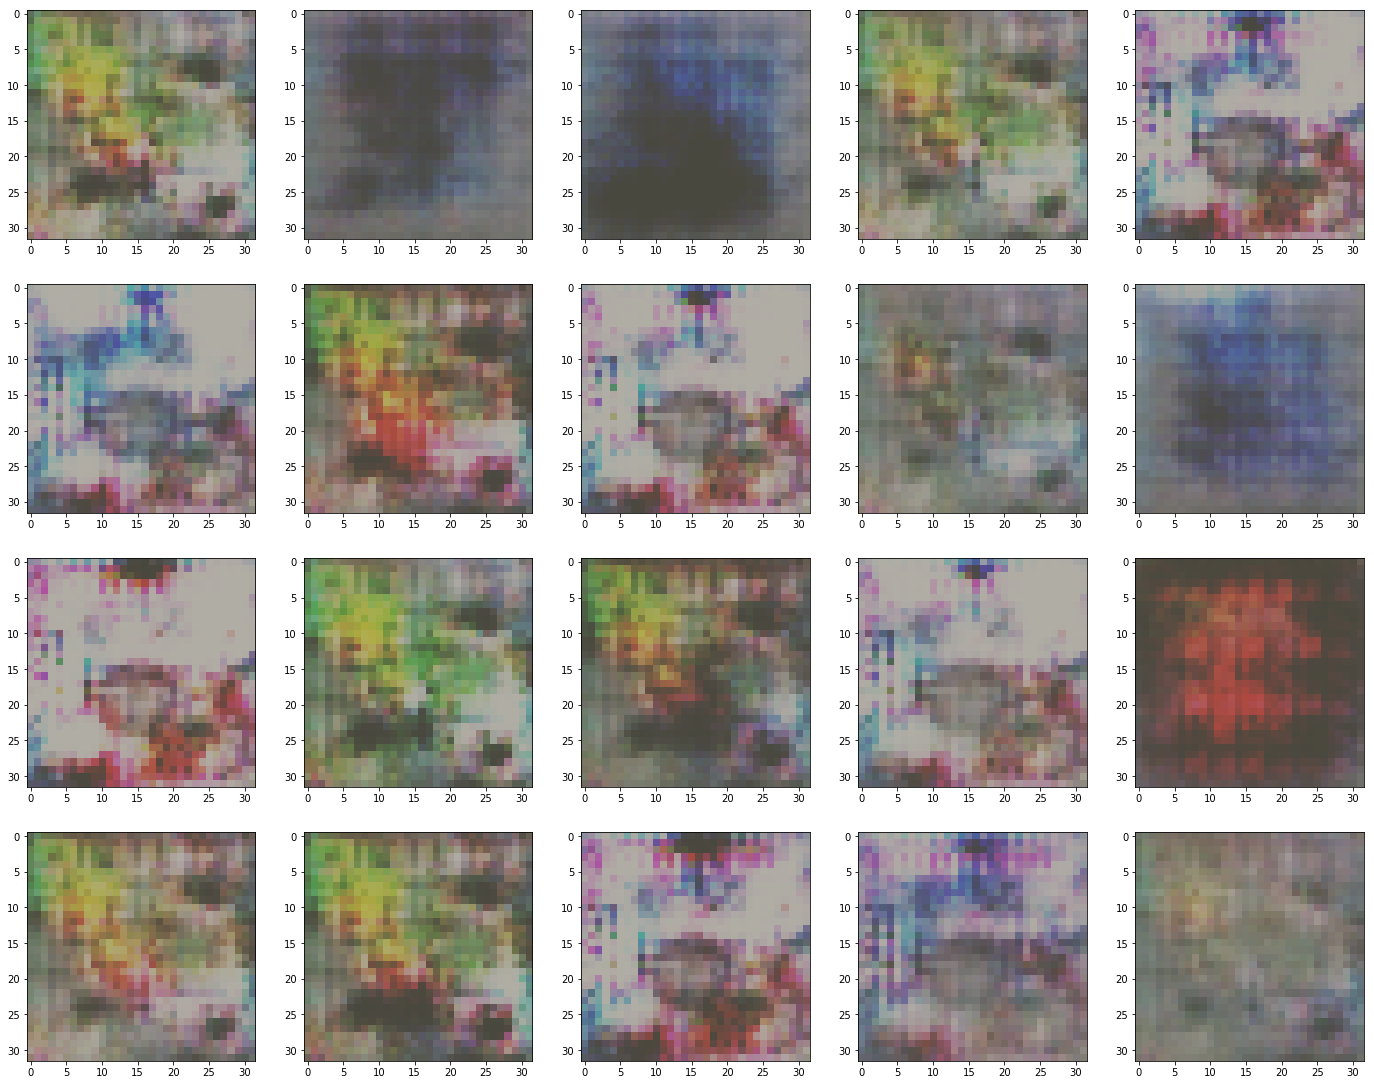

In [21]:
#Testing of decoder's copy 

dec=netG
noise.data.resize_(batch_size, nz, 1, 1)
noise.data.normal_(0, 1)
gen = netG.decoder(noise)


width = 24
height = 100
plt.figure(figsize=(width, height))

hidden_vector=torch.randn((10,20))
hidden_vector=Variable(hidden_vector.cuda())

img=gen.data.cpu().numpy().reshape((batch_size,3,imageSize,imageSize))

for i in range(20):
    plt.subplot(20,5,i+1)
    sigma=np.array([0.4914, 0.4822, 0.4465])
    mu=np.array([0.2023, 0.1994, 0.2010])
    img[i]=img[i]*mu[:,None, None] + sigma[:,None, None]
    plt.imshow(np.transpose(img[i], (1, 2, 0)))